# Systematics retrieval on stars with/without calibrators:

In this notebook, I will demonstrate the ability to simultanously fit for systematics along with the radius of stars. 

Firstly, I will take a trivial example most often seen with CHARA/PAVO data: observations of a star bracketed by observations of a calibrator which is assumed to be unresolved and has the same systematics as the target star. 

Then, I will extend this to N stars without an explicit calibrator--this should mimic the case where the calibrators are not partially resolved so we must infer their radii alongside the target star. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#this is the way I've found to get jax to use multiple CPU cores on Apple Silicon
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"

import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer

import arviz as az

import corner

## Creating (an approximation) of the CHARA array:

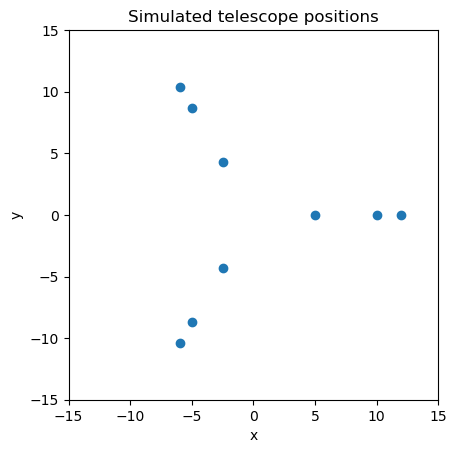

In [2]:
thetas = jnp.array([0,0,0,120,120,120,240,240,240])
radii = jnp.array([5,10,12,5,10,12,5,10,12])

station_x = radii * jnp.cos(thetas*jnp.pi/180)
station_y = radii * jnp.sin(thetas*jnp.pi/180)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Simulated telescope positions")
plt.scatter(station_x, station_y)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.gca().set_aspect('equal', adjustable='box')

In [3]:
u = np.subtract.outer(station_x,station_x)
u = u.T[np.where(~np.eye(u.shape[0],dtype=bool))]
v = np.subtract.outer(station_y,station_y)
v = v.T[np.where(~np.eye(v.shape[0],dtype=bool))]

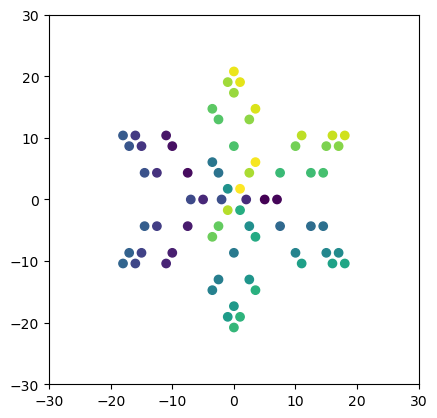

In [4]:
plt.scatter(u,v,c=np.arange(len(u)))
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.gca().set_aspect('equal', adjustable='box')

## One target star and one calibrator:

First, let's define our systematic: each point is perturbed by an arbitrary value between 0.25 and 0.75. This value is consistent between the target star and calibrator. In this trivial example we could even divide the target by the calibrator to remove the systematic. However, sampling in numpyro allows us to propagate errors to the final model, and the same framework is extensible to fully hierarchical calibration.

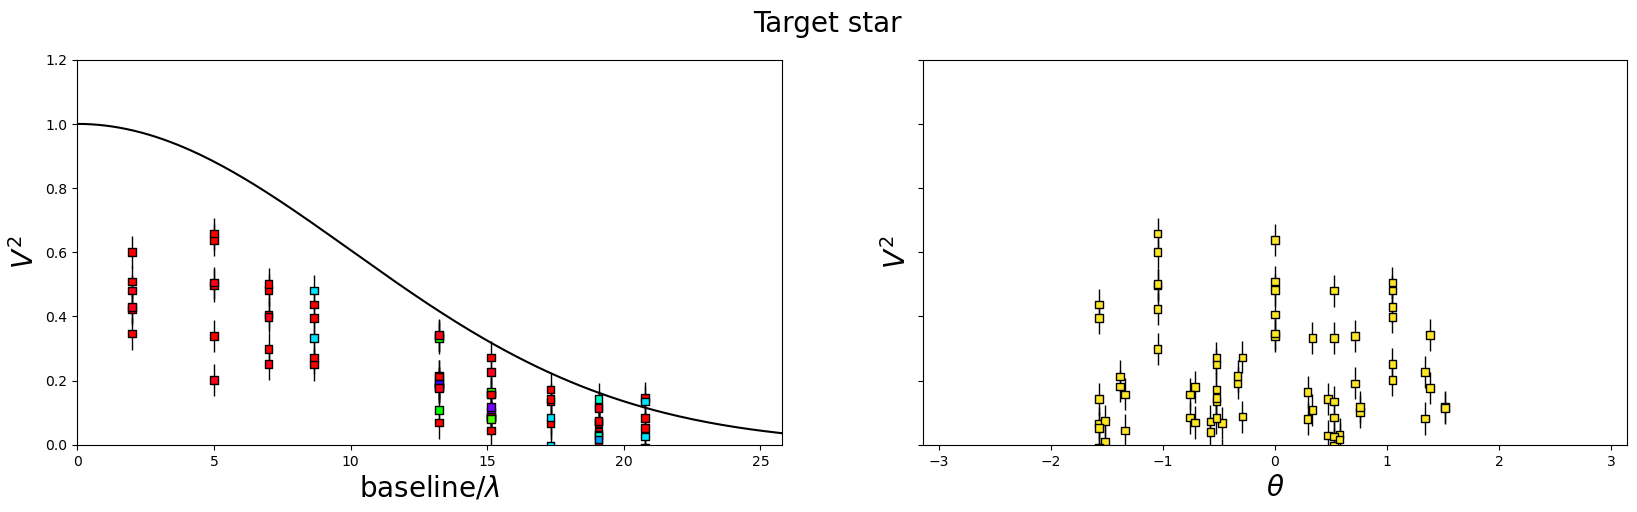

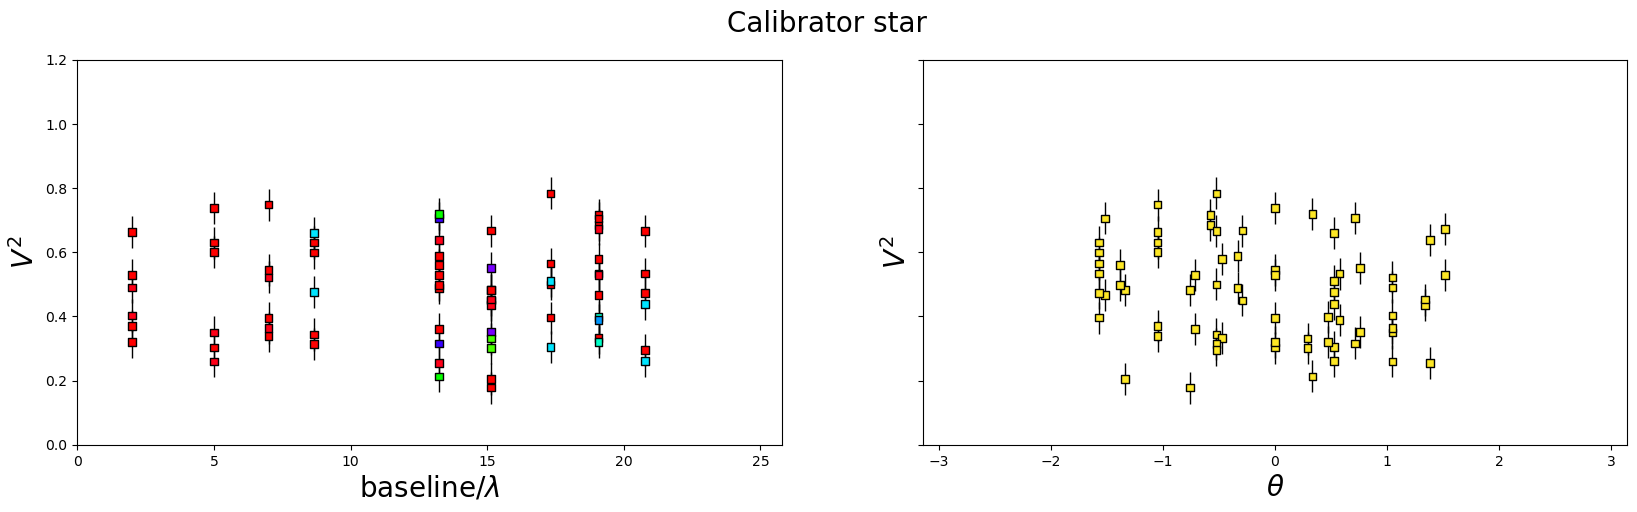

In [5]:
x = jnp.hypot(u,v)
theta = jnp.arctan(v/u)

#parameters of the Gaussian
true_params = [10]


# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)

yerr = 0.05

systematic = np.random.uniform(0.25,0.75, len(x))

#gaussian
y = np.exp(-((x)**2)/(2*true_params[0]**2))*systematic + yerr * np.random.randn(len(x))

y_calib = systematic + yerr * np.random.randn(len(x))


# Then save the *true* line.
x0 = np.linspace(0, jnp.max(x)+5.0, 200)
y0 = np.exp(-((x0)**2)/(2*true_params[0]**2))

cmap = plt.get_cmap("hsv")
cmap2 = plt.get_cmap("viridis")



def plot_data():
    #plot the target star's vis squared
    fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
    ax[0].errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[0].scatter(x, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap(theta))
    ax[0].plot(x0, y0, color="k", lw=1.5)
    ax[0].set_xlabel("baseline/$\lambda$", fontsize=20)
    ax[0].set_ylabel("$V^2$", fontsize=20)
    ax[0].set_ylim(0, 1.2)
    ax[0].set_xlim(0, jnp.max(x0))
    fig.suptitle("Target star",fontsize=20)
    
    ax[1].errorbar(theta, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[1].scatter(theta, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap2(x))
    ax[1].set_xlabel(r"$\theta$", fontsize=20)
    ax[1].set_ylabel("$V^2$", fontsize=20)
    ax[1].set_ylim(0, 1.2)
    ax[1].set_xlim(-np.pi, np.pi)
    
    #plot the calibrator vis squared
    fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
    ax[0].errorbar(x, y_calib, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[0].scatter(x, y_calib, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap(theta))
    ax[0].set_xlabel("baseline/$\lambda$", fontsize=20)
    ax[0].set_ylabel("$V^2$", fontsize=20)
    ax[0].set_ylim(0, 1.2)
    ax[0].set_xlim(0, jnp.max(x0))
    
    ax[1].errorbar(theta, y_calib, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[1].scatter(theta, y_calib, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap2(x))
    ax[1].set_xlabel(r"$\theta$", fontsize=20)
    ax[1].set_ylabel("$V^2$", fontsize=20)
    ax[1].set_ylim(0, 1.2)
    ax[1].set_xlim(-np.pi, np.pi)
    fig.suptitle("Calibrator star",fontsize=20)


plot_data()

Our numpyro model consists of a plate of independent samples of the systematic artifact, 

In [6]:
def gaussian_model(u,v,sigma):
    x = jnp.hypot(u,v)
    theta = jnp.arctan(v/u)
    
    return jnp.exp(-((x)**2)/(2*sigma**2))

def model_systematic(u,v, yerr, y=None, y_calib=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
  
    sigma = numpyro.sample("diam", dist.Uniform(0, 20))
    with numpyro.plate("data",len(y)):
        sys = numpyro.sample("sys", dist.Uniform(0.25, 0.75))
        
    gm = gaussian_model(u,v,sigma)*sys
    calib = sys
    with numpyro.plate("data",len(y)):    
        numpyro.sample("y_calib", dist.Normal(calib, yerr), obs=y_calib)
        numpyro.sample("y", dist.Normal(gm, yerr), obs=y)

In [7]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(model_systematic),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), u, v, yerr, y=y, y_calib=y_calib)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 2.5 s, sys: 73.5 ms, total: 2.57 s
Wall time: 2.13 s


In [8]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diam,9.957,0.224,9.534,10.358,0.003,0.002,6279.0,2830.0,1.0
sys[0],0.339,0.037,0.268,0.407,0.001,0.000,3081.0,1167.0,1.0
sys[1],0.572,0.040,0.500,0.651,0.000,0.000,6471.0,2315.0,1.0
sys[2],0.361,0.039,0.288,0.435,0.001,0.000,3239.0,1286.0,1.0
sys[3],0.515,0.047,0.431,0.608,0.001,0.000,6946.0,2378.0,1.0
...,...,...,...,...,...,...,...,...,...
sys[67],0.475,0.049,0.385,0.569,0.001,0.000,6298.0,2480.0,1.0
sys[68],0.666,0.043,0.594,0.747,0.001,0.000,4177.0,1782.0,1.0
sys[69],0.533,0.048,0.446,0.623,0.001,0.000,7837.0,2341.0,1.0
sys[70],0.517,0.039,0.446,0.591,0.000,0.000,8095.0,2664.0,1.0


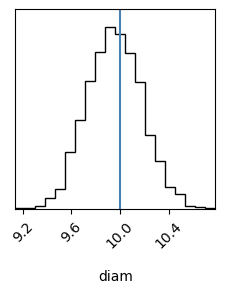

In [9]:
corner.corner(inf_data, var_names=["diam"], truths=true_params);

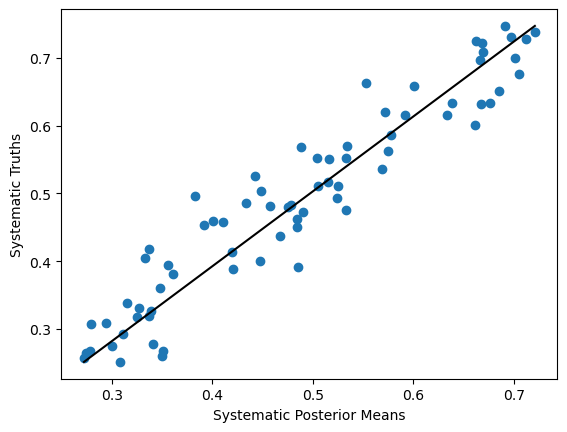

In [10]:
sys_posterior_means = np.mean(inf_data.posterior.sys, axis=(0,1))
plt.scatter(sys_posterior_means,systematic)
plt.plot([sys_posterior_means.min(), sys_posterior_means.max()],[systematic.min(), systematic.max()],c='k')
plt.xlabel("Systematic Posterior Means")
plt.ylabel("Systematic Truths");

## Ensemble of stars with different radii:

Now, we will do the same, except with an ensemble of stars which are not explicitly calibrators but all share the same systematic. The goal will be to infer the radii of each star alongside the systematic effect. 

In [11]:
np.random.seed(40)
num_stars = 10
sigmas = np.random.uniform(5,20,num_stars)
#parameters of the Gaussian

# For reproducibility, let's set the random number seed and generate the data:

yerr = 0.05

systematic = np.random.uniform(0.25,0.75, len(x))

#gaussian
y = np.exp(-((x)**2)/(2*sigmas[np.newaxis,:].T**2))*systematic + yerr * np.random.randn(num_stars,x.shape[0])


# Then save the *true* line.
x0 = np.linspace(0, jnp.max(x)+5.0, 200)
y0 = np.exp(-((x0)**2)/(2*sigmas[np.newaxis,:].T**2))

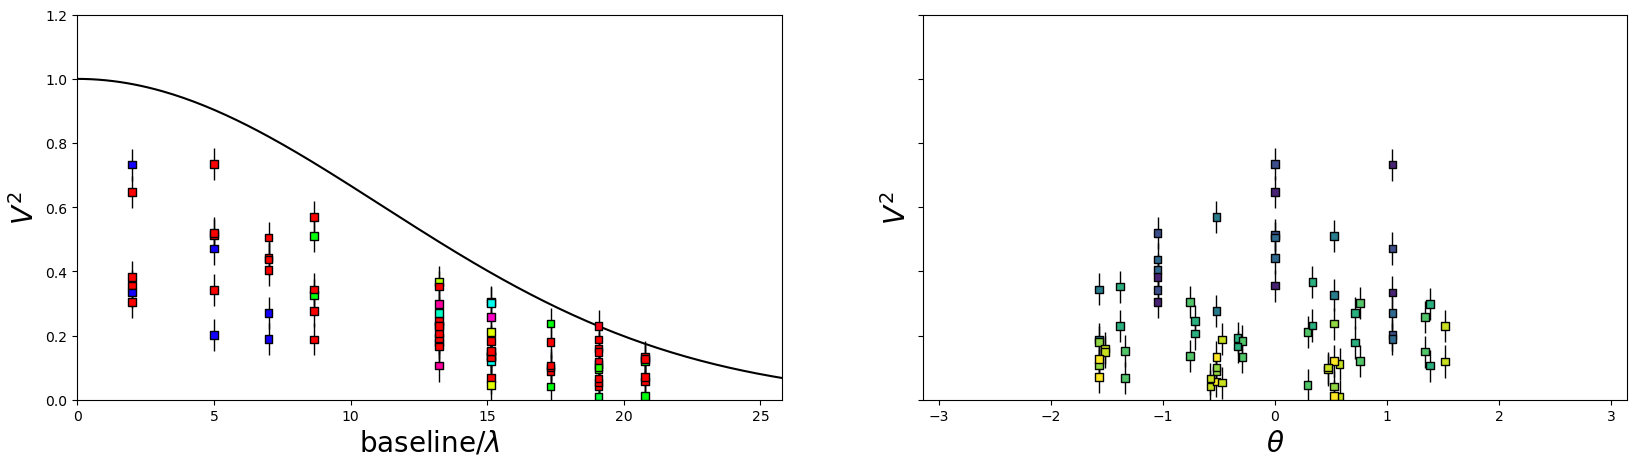

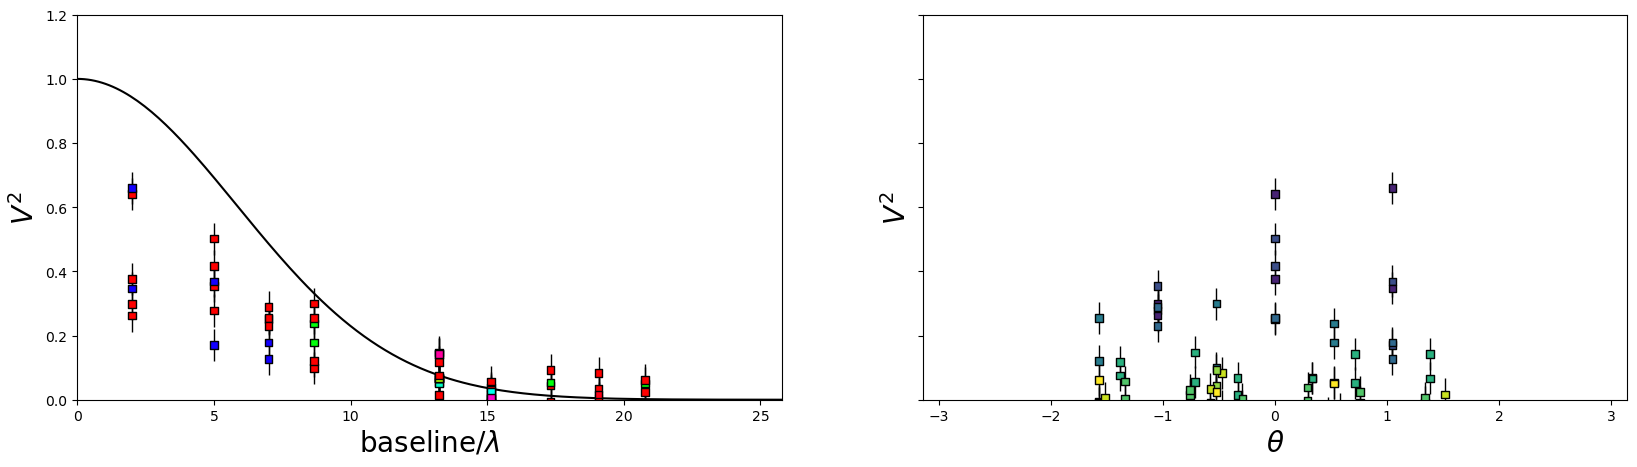

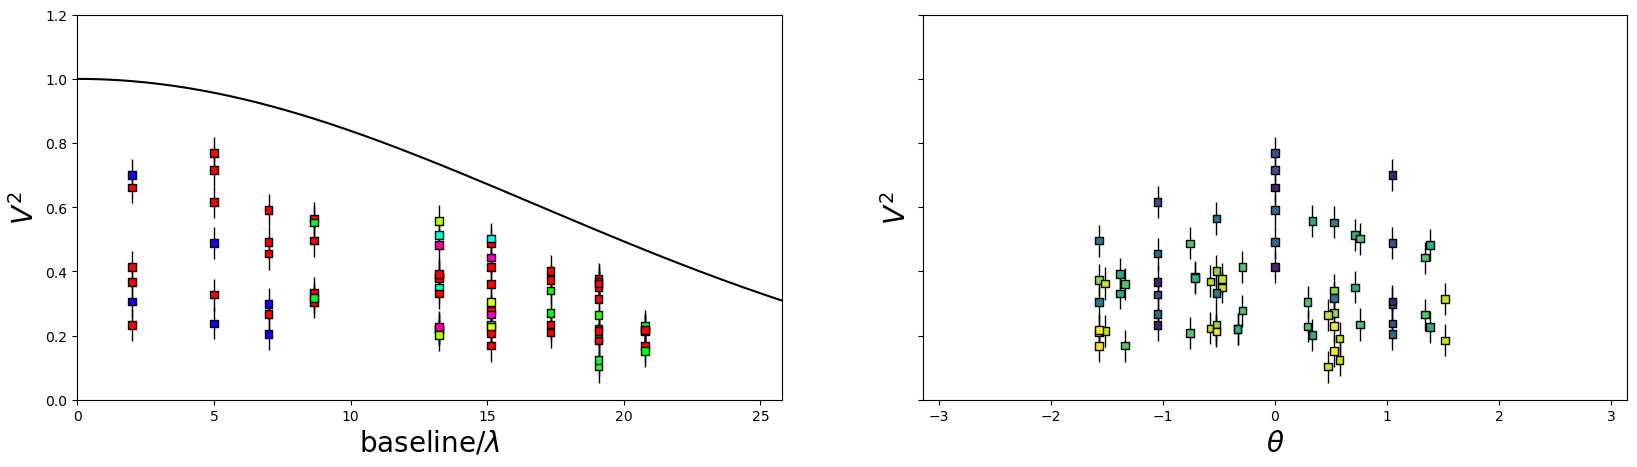

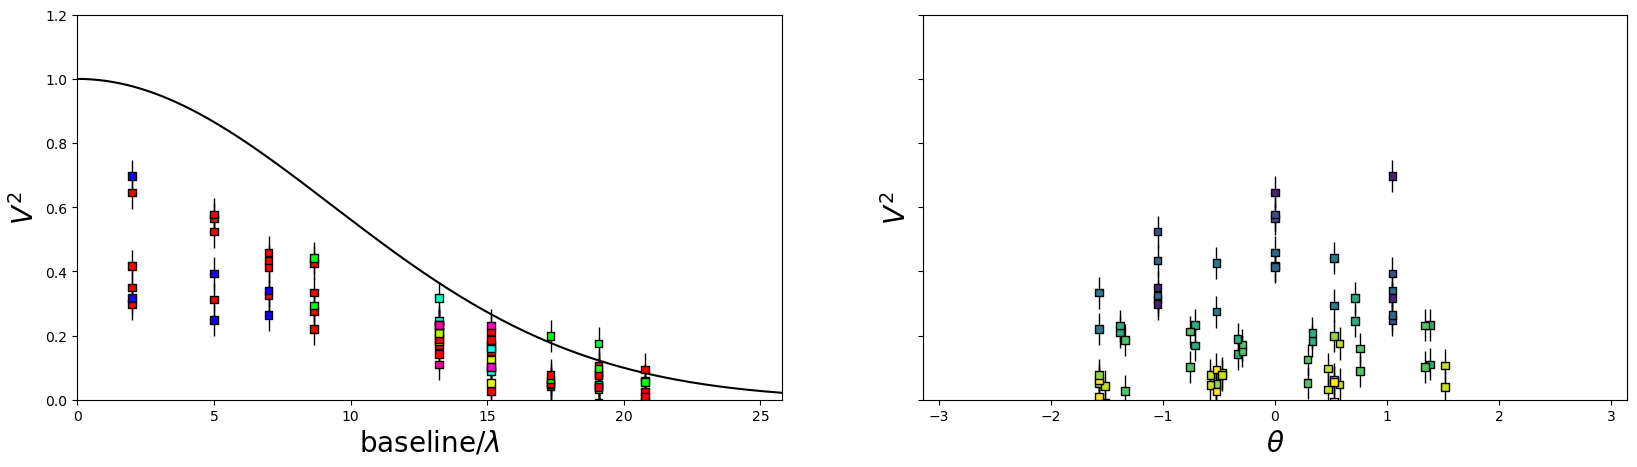

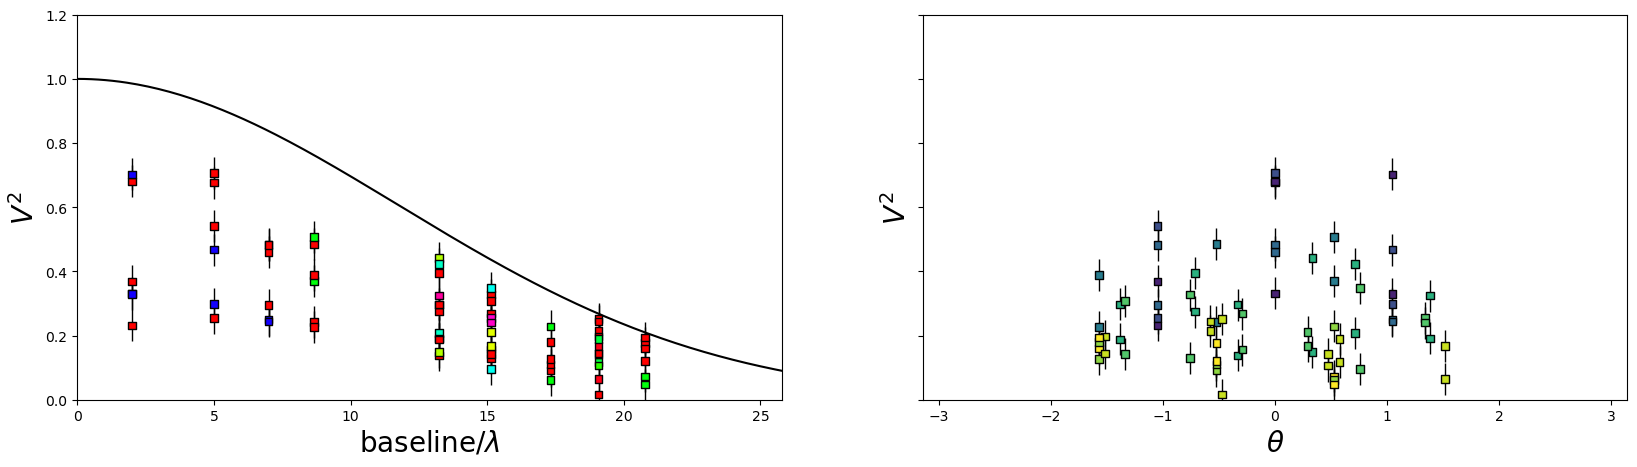

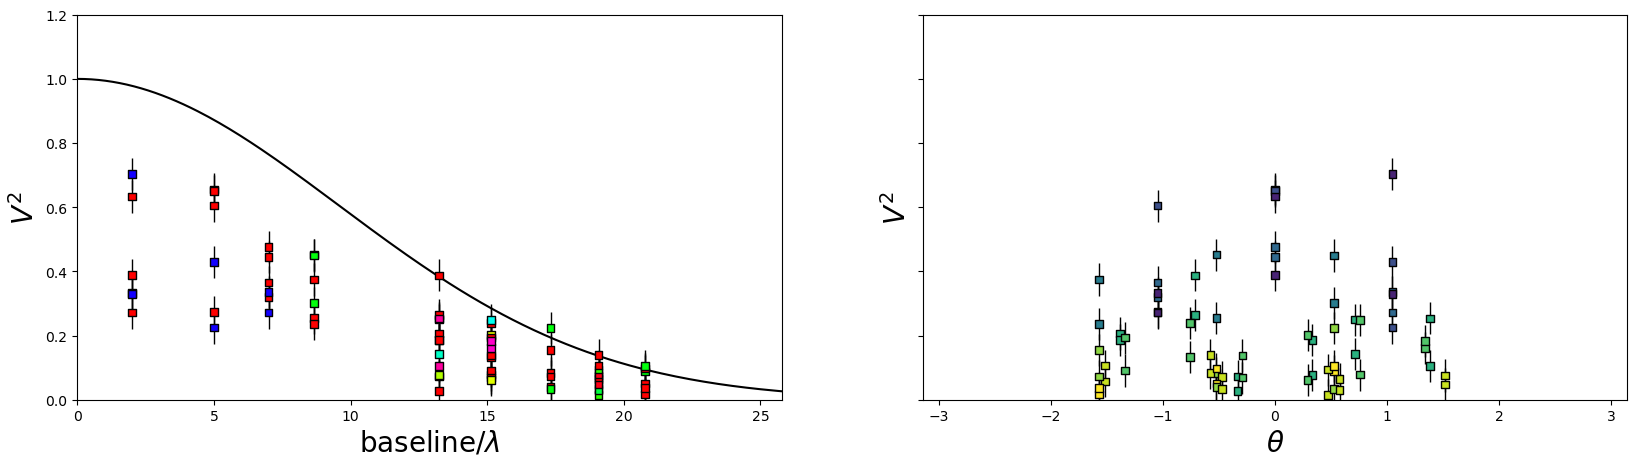

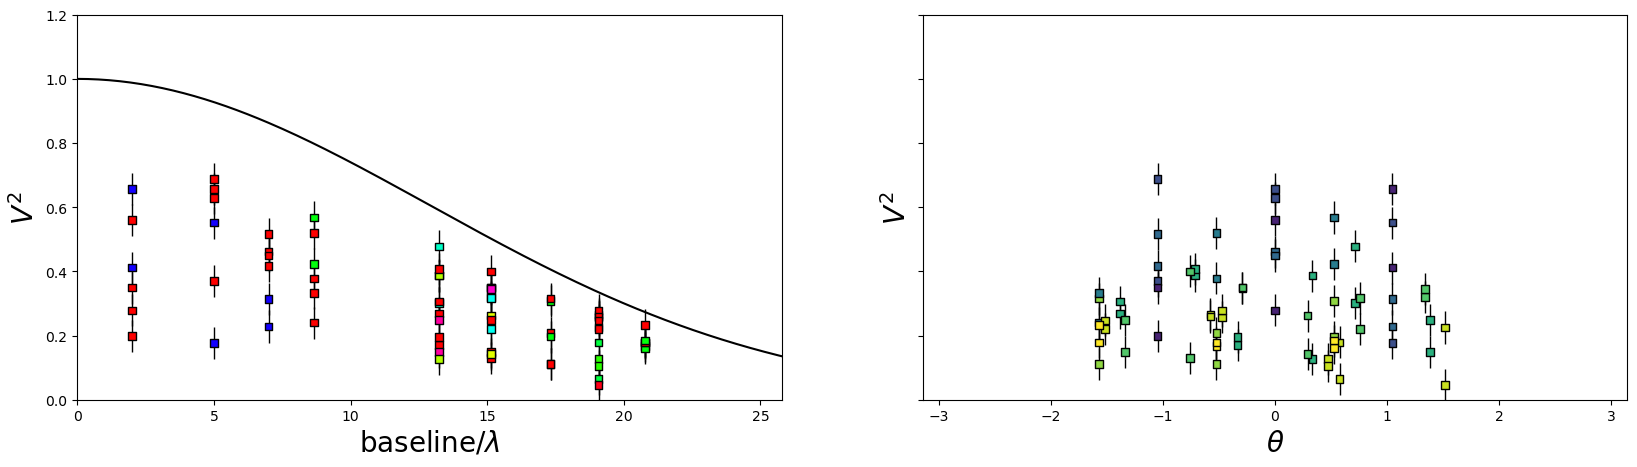

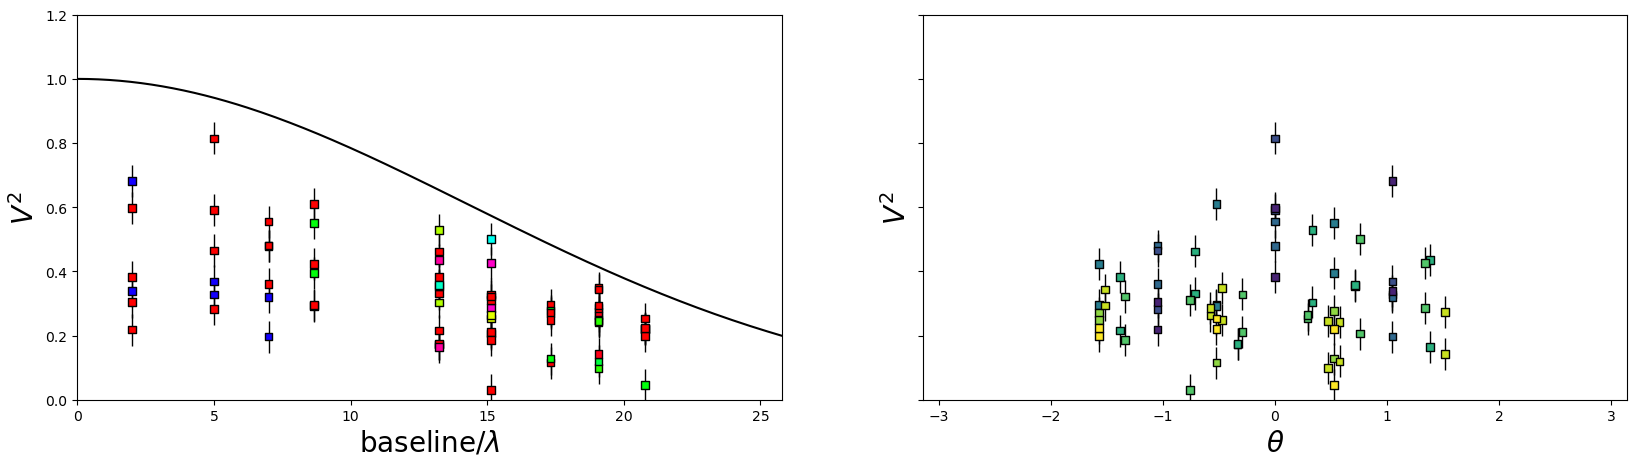

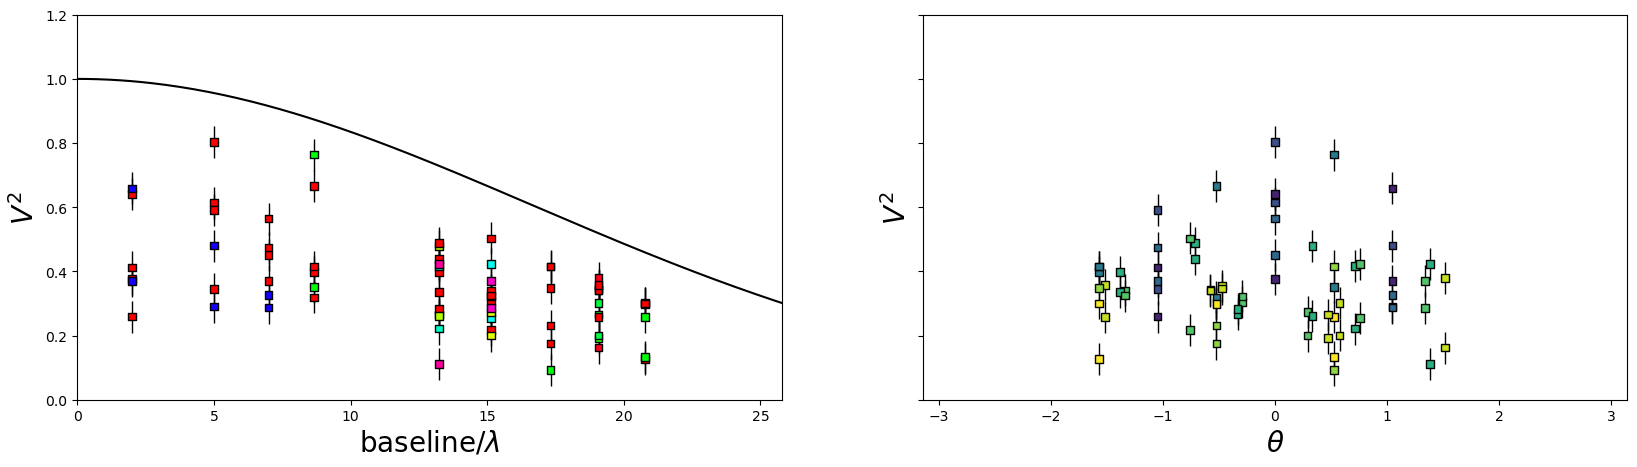

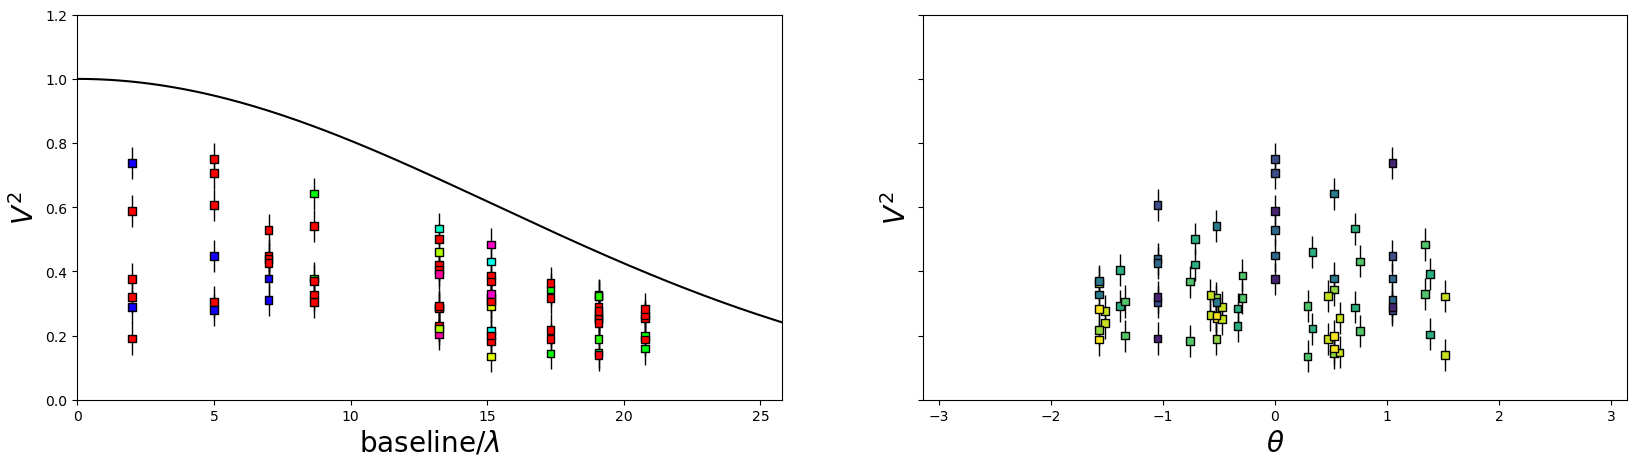

In [12]:
def plot_data(x, y, x0, y0, yerr):
    fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
    
    ax[0].errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[0].scatter(x, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap(theta/theta.max()))
    ax[0].plot(x0, y0, color="k", lw=1.5)
    ax[0].set_xlabel("baseline/$\lambda$", fontsize=20)
    ax[0].set_ylabel("$V^2$", fontsize=20)
    ax[0].set_ylim(0, 1.2)
    ax[0].set_xlim(0, jnp.max(x0))
    
    ax[1].errorbar(theta, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[1].scatter(theta, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap2(x/x.max()))
    ax[1].set_xlabel(r"$\theta$", fontsize=20)
    ax[1].set_ylabel(r"$V^2$", fontsize=20)
    ax[1].set_ylim(0, 1.2)
    ax[1].set_xlim(-np.pi, np.pi)
    
for i, sigma in enumerate(sigmas):
    plot_data(x,y[i], x0, y0[i], yerr)

In [13]:
def model_multi_systematic(u,v, yerr, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.


    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with numpyro.plate("stars", y.shape[0],dim=-2):
        sigma = numpyro.sample("sigma", dist.Uniform(0, 20))
    
        
    with numpyro.plate("data",y.shape[1]):
        sys = numpyro.sample("sys", dist.Uniform(0.25, 0.75))
        
    gm = gaussian_model(u,v,sigma)*sys
    with numpyro.plate("data",y.shape[1]):    
        numpyro.sample("y", dist.Normal(gm, yerr), obs=y)

In [14]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(model_multi_systematic),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), u, v, yerr, y=y)

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/jax/linear_util.py:167: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 2.77 s, sys: 42.2 ms, total: 2.81 s
Wall time: 2.15 s


In [15]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"sigma[0, 0]",10.703,0.239,10.241,11.141,0.008,0.006,936.0,1708.0,1.0
"sigma[1, 0]",6.157,0.189,5.809,6.516,0.003,0.002,4900.0,2621.0,1.0
"sigma[2, 0]",15.988,0.556,14.977,17.030,0.025,0.017,536.0,985.0,1.0
"sigma[3, 0]",9.449,0.212,9.051,9.836,0.005,0.004,1519.0,2471.0,1.0
"sigma[4, 0]",11.879,0.288,11.349,12.423,0.010,0.007,831.0,1568.0,1.0
...,...,...,...,...,...,...,...,...,...
sys[67],0.671,0.035,0.609,0.736,0.001,0.001,1108.0,1570.0,1.0
sys[68],0.334,0.043,0.256,0.409,0.001,0.001,2349.0,1613.0,1.0
sys[69],0.640,0.054,0.546,0.742,0.001,0.001,1298.0,1705.0,1.0
sys[70],0.298,0.019,0.261,0.331,0.000,0.000,5043.0,2003.0,1.0


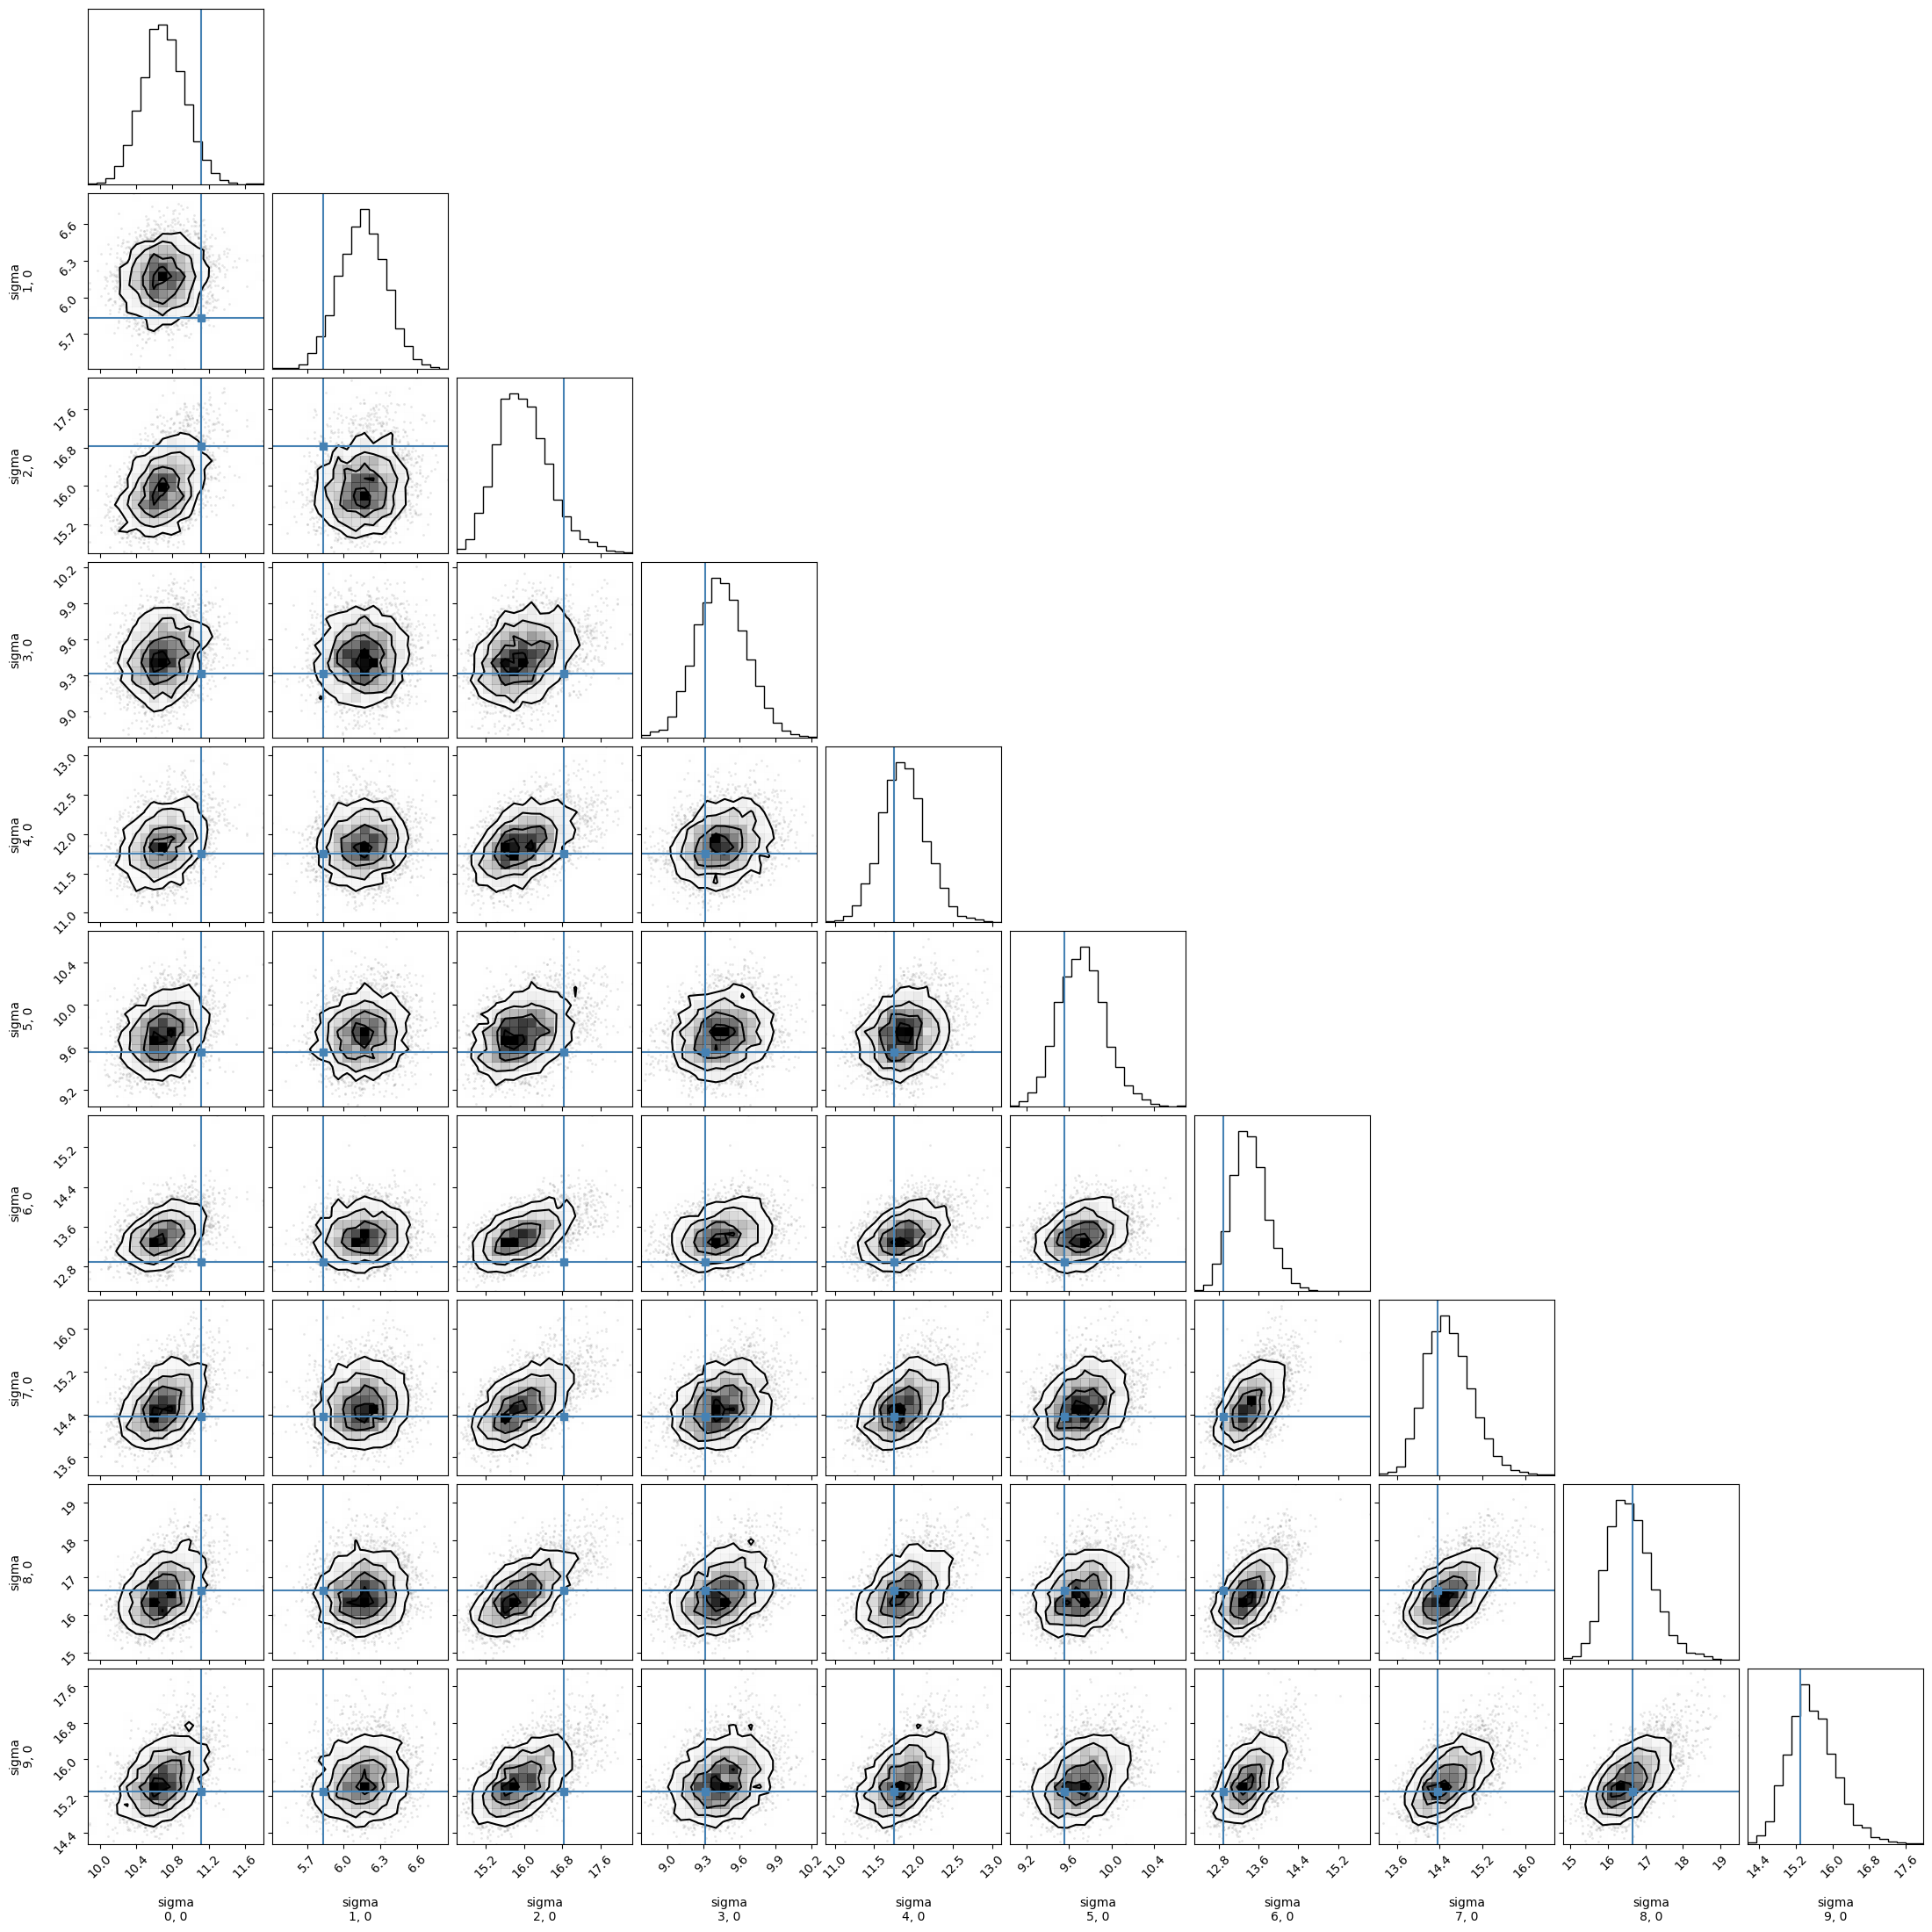

In [16]:
corner.corner(inf_data, var_names=["sigma"], truths=sigmas);

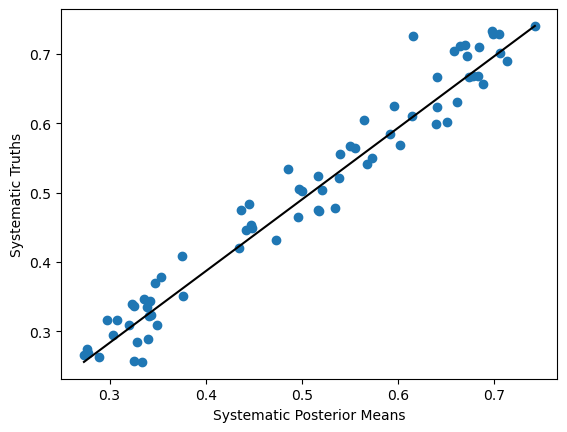

In [17]:
sys_posterior_means = np.mean(inf_data.posterior.sys, axis=(0,1))
plt.scatter(sys_posterior_means,systematic)
plt.plot([sys_posterior_means.min(), sys_posterior_means.max()],[systematic.min(), systematic.max()],c='k')
plt.xlabel("Systematic Posterior Means")
plt.ylabel("Systematic Truths");